# Basic "Avodaco prices" dataset exploration

I have chosen this high rated dataset on kaggle, because I hope this exploration will give me some interesting results and broaden my knowledge. Detailed description you can be found [here](https://www.kaggle.com/neuromusic/avocado-prices/home)

This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. Here's how the Hass Avocado Board describes the data on their [website](http://www.hassavocadoboard.com/retail/volume-and-price-data)

In this task we will follow this schedule:
1. Data preparation
2. Visualizations
3. Preparing for Machine Learning
4. Machine Learning
5. Conclusions


## Chapter 1. Let's prepare the patient for the surgery

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
sns.set()

In [2]:
data = pd.read_csv('avocado.csv')
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


We will clear our data a little:
1. Remove 'Unnamed: 0' - this is the number of week in particular year (we start the counting from the end of the year)
2. Set the datetime index - it is much more conveniet to use, compare, plot etc.
3. Drop 'TotalUS' region - this is not in our scope of work, we want to comapre the situation in different regions, this data will be a kind of outlier we do not desire.
4. Add new columns to check the linear corelations between columns (TB_minus, TV_minus)

In [3]:
columns_for_drop = ['Unnamed: 0', 'year'] 

data = pd.read_csv('avocado.csv', index_col='Date', parse_dates=True).drop(columns_for_drop, axis = 1)
data = data[data.region != 'TotalUS']

#TB_minus describes possible linear correlation of "Total Bags" feature.
data['TB_minus'] = (data['Total Bags']-data['Small Bags']-data['Large Bags']-data['XLarge Bags']).round(2)
#TV_minus describes possible linear correlation of "Total Volume"
data['TV_minus'] = (data['Total Volume']-data['4046']-data['4225']-data['4770'] - data['Total Bags']).round(2)

data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,TB_minus,TV_minus
Date,,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany,0.0,0.0
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany,-0.0,0.0
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany,0.0,0.0
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany,0.0,-0.0
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany,-0.0,-0.0


It would be great to divide our features into _numerical_ and _categorical_

In [4]:
data_kinds = np.array([dtype.kind for dtype in data.dtypes])
num_cols = data.columns[data_kinds != 'O']
cat_cols = data.columns[data_kinds == 'O']
print('Numerical columns: {} pcs \n {}'.format(len(num_cols), num_cols.values))
print()
print('Categorical columns: {} pcs \n {}'.format(len(cat_cols), cat_cols.values))

Numerical columns: 11 pcs 
 ['AveragePrice' 'Total Volume' '4046' '4225' '4770' 'Total Bags'
 'Small Bags' 'Large Bags' 'XLarge Bags' 'TB_minus' 'TV_minus']

Categorical columns: 2 pcs 
 ['type' 'region']


In [5]:
#let's have a quick look at the Categorical columns
for cat_col in cat_cols:
    print('Column: "{}"'.format(str(cat_col)))
    print(data[cat_col].value_counts())
    print()

Column: "type"
conventional    8957
organic         8954
Name: type, dtype: int64

Column: "region"
SanDiego               338
Southeast              338
NewOrleansMobile       338
Columbus               338
Seattle                338
Detroit                338
Houston                338
Louisville             338
Boise                  338
Philadelphia           338
Denver                 338
PhoenixTucson          338
Chicago                338
BaltimoreWashington    338
Pittsburgh             338
Northeast              338
NewYork                338
Jacksonville           338
Midsouth               338
GreatLakes             338
Tampa                  338
NorthernNewEngland     338
GrandRapids            338
RaleighGreensboro      338
LasVegas               338
Albany                 338
StLouis                338
Spokane                338
Plains                 338
Charlotte              338
Boston                 338
SouthCarolina          338
West                   338
RichmondN

At the first look we notice that there are 3 observations missing of type = 'organic' in  region = 'WestTexNewMexico'. Maybye there is _a-week-without-avocado_ in this region? Let's find out!

In [6]:
# our mask which does not contain some of weeks 
missing_mask = ((data['type'] == 'organic') & (data['region'] == 'WestTexNewMexico'))

# full (standard) mask of weeks copied from one of the other regions 
standard_mask = ((data['type'] == 'organic') & (data['region'] == 'Boise'))

filter_mask = pd.Series(data[standard_mask].index).isin(pd.Series(data[missing_mask].index))

missing_index_values = (data[standard_mask].index)[~filter_mask]
print('''Missing observations:
type = "organic"
region = "WestTexNewMexico"
for the following dates:''')
for t in missing_index_values:
    print(t.strftime('%Y-%m-%d'))

Missing observations:
type = "organic"
region = "WestTexNewMexico"
for the following dates:
2015-12-06
2017-06-25
2017-06-18


For now we will leave this issue. This demands further consideration.

In [7]:
data.describe().round(2)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,TB_minus,TV_minus
count,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00
mean,1.41,539258.69,183807.41,188223.11,14551.23,152675.73,116202.87,34505.69,1967.17,0.00,1.20
std,0.40,1224331.91,515105.86,451985.65,48817.54,364599.23,278759.60,113947.74,8186.40,0.06,35.53
min,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00
25%,1.10,10571.02,819.66,2909.61,0.00,4905.20,2700.34,113.00,0.00,0.00,0.00
50%,1.37,100154.13,7824.43,26701.99,164.23,37551.02,24530.62,2459.22,0.00,0.00,0.00
75%,1.67,400176.68,101488.82,131755.22,5736.74,103691.60,79282.59,19421.71,106.76,0.00,0.00
max,3.25,11274749.11,5160896.68,5402444.45,804558.25,4145406.70,3403581.49,2838239.39,131300.76,1.00,3886.10


Check of linear correlation:
1. TB_minus indeed indicates linear correlation of "Total Bags" feature. It's max and min are 1 and -1
2. TV_minus describes possible linear correlation of "Total Volume". In this case we are not so sure. Let's check this.

In [8]:
# find highest TV_minus values
data.sort_values(by = ['TV_minus'], ascending=False).head(5)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,TB_minus,TV_minus
Date,,,,,,,,,,,,,
2017-07-16,1.64,209543.04,4180.21,76793.36,0.0,124683.37,79403.55,45279.82,0.0,organic,GreatLakes,-0.0,3886.10
2018-03-25,1.47,182492.41,5140.14,51115.63,0.0,125061.81,102033.82,23027.99,0.0,organic,GreatLakes,-0.0,1174.83
2018-02-25,1.49,176612.49,4528.42,51477.74,0.0,119576.40,86332.21,33244.19,0.0,organic,GreatLakes,-0.0,1029.93
2018-03-04,1.33,222950.32,6008.33,68134.36,0.0,147949.04,119193.36,28755.68,0.0,organic,GreatLakes,0.0,858.59
2017-07-16,1.48,10838.58,120.61,3149.03,0.0,6713.33,4037.21,2676.12,0.0,organic,Indianapolis,0.0,855.61


In [9]:
(
    data.assign(TV_percent = ((data['TV_minus'] / data['Total Volume'])*100).round(2))
    .sort_values(by = ['TV_percent'], ascending=False)
    .head(10)
)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,TB_minus,TV_minus,TV_percent
Date,,,,,,,,,,,,,,
2017-07-16,1.48,10838.58,120.61,3149.03,0.0,6713.33,4037.21,2676.12,0.0,organic,Indianapolis,0.0,855.61,7.89
2018-03-04,1.23,10713.61,283.05,1481.74,0.0,8706.42,6217.00,2489.42,0.0,organic,Indianapolis,0.0,242.40,2.26
2017-07-16,1.64,209543.04,4180.21,76793.36,0.0,124683.37,79403.55,45279.82,0.0,organic,GreatLakes,-0.0,3886.10,1.85
2017-12-10,1.39,13710.63,435.76,2561.62,0.0,10540.47,9555.71,984.76,0.0,organic,Detroit,0.0,172.78,1.26
2018-03-25,1.43,20507.49,687.46,2729.79,0.0,16887.00,13920.18,2966.82,0.0,organic,Detroit,-0.0,203.24,0.99
2017-07-16,1.82,22784.26,201.83,5849.35,0.0,16507.04,2066.65,14440.39,0.0,organic,CincinnatiDayton,0.0,226.04,0.99
2017-07-30,1.85,14874.38,286.35,6566.23,0.0,7882.30,2278.78,5603.52,0.0,organic,CincinnatiDayton,0.0,139.50,0.94
2017-11-05,1.58,17353.24,518.90,2512.04,0.0,14161.72,13656.25,505.47,0.0,organic,Detroit,-0.0,160.58,0.93
2017-08-13,1.97,7797.08,219.37,4075.78,0.0,3432.91,2701.68,731.23,0.0,organic,CincinnatiDayton,0.0,69.02,0.89


TV_percent is a percentage of "Total Volume" which is different from our linear correlation assumption. Only 4 observations have more than 1% relative difference. We may assume that 'Total Volume' and 'Total Bags' are linearly correlated with other columns. It is worth to know which features are correlated to spare time and avoid Machine Learning errors.

TB_minus, TV_minus, TV_percent are no longer needed. We will get rid of them.

In [10]:
data.drop(['TB_minus', 'TV_minus'], axis = 1, inplace=True)
data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


In [11]:
data.isna().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
dtype: int64

At first glance it seems that there is no danger beneath the sea surface. We are ready to dive a little bit deeper.

## Chapter 2. Visualize it

We will make a couple of plots to get some intuition how the 'AveragePrice' behaves due to the categorical values "type" and "region"

In [12]:
data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


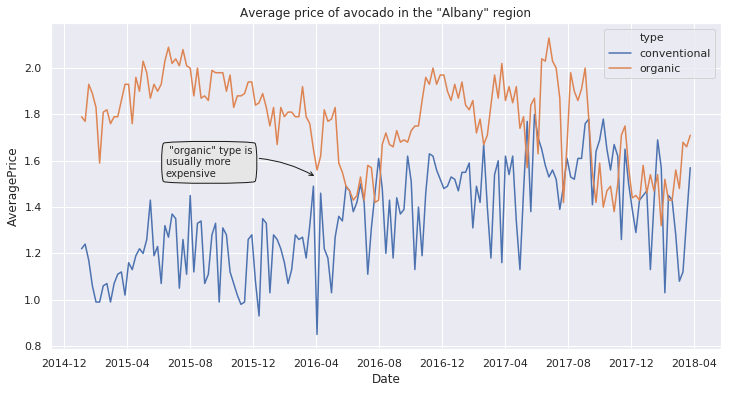

In [13]:
annot_customize_dict = dict(xycoords='data', 
                            textcoords='offset points', 
                            bbox=dict(boxstyle="round4,pad=.5", fc="0.9", color = 'k'),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color = 'k'))

fig, ax = plt.subplots(figsize = (12,6))
g = sns.lineplot(x = data[data.region == 'Albany'].index, 
                 y = 'AveragePrice', 
                 hue = 'type',
                 data=data[data.region == 'Albany'],
                 err_style=None)

ax.annotate(
    """ \"organic\" type is
usually more
expensive""",
    xy=('2016-04-1', 1.53),
    xytext=(-150, 0),
    **annot_customize_dict)

plt.title('Average price of avocado in the "Albany" region');

In [14]:
regions_chosen = ['Spokane', 'Denver']
types_chosen = ['organic', 'conventional']

data2 = data[data.region.isin(regions_chosen) & data.type.isin(types_chosen)]
data2.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,0.98,625475.10,93034.20,246747.13,19103.69,266590.08,38620.02,227884.21,85.85,conventional,Denver
2015-12-20,1.05,528944.54,113403.55,188263.20,24477.83,202799.96,34993.02,167806.94,0.00,conventional,Denver
2015-12-13,0.83,741702.50,96222.34,321764.32,29349.34,294366.50,34244.40,260040.92,81.18,conventional,Denver
2015-12-06,0.76,838225.19,111259.34,378124.28,8807.96,340033.61,35086.04,304844.07,103.50,conventional,Denver
2015-11-29,1.12,429109.64,85241.45,179982.42,14146.28,149739.49,31920.41,117819.08,0.00,conventional,Denver


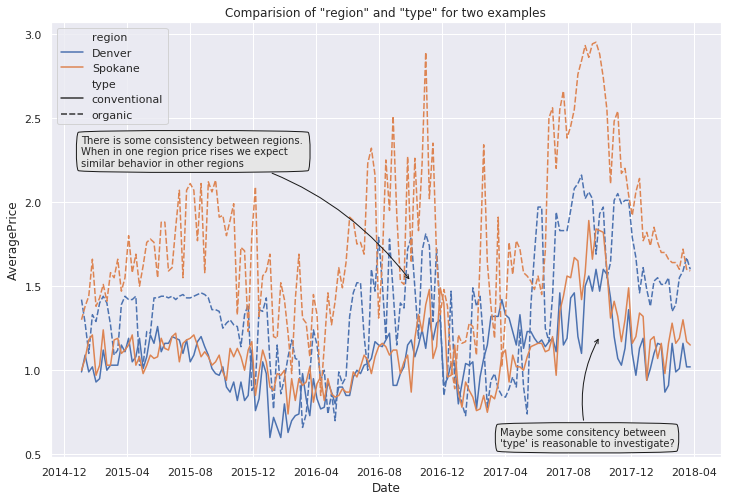

In [15]:
fig, ax = plt.subplots(figsize = (12,8))

g = sns.lineplot(x = data2.index, 
                 y = 'AveragePrice', 
                 hue = 'region',
                 style = 'type',
                 data=data2,
                 err_style=None)

ax.annotate(
"""There is some consistency between regions. 
When in one region price rises we expect 
similar behavior in other regions""", 
            xy=('2016-10-1', 1.53), 
            xytext=(-330, 115), 
            **annot_customize_dict)

ax.annotate(
"""Maybe some consitency between 
'type' is reasonable to investigate?""", 
            xy=('2017-10-1', 1.2), 
            xytext=(-100, -110), 
            **annot_customize_dict);
ax.set_title('Comparision of "region" and "type" for two examples');

We will mark on the timeline with red color periods of time when 'organic' type was more expensive than 'conventonal' 

OME (Organic More Expensive) = (summary amount of time when organic type was more expensive) / (total amount of time)

In [16]:
def create_filled_subplot(region, ax = None, legend = None):
    if ax == None:
        ax = plt.gca()
    data2 = data[data.region == region]
    pt = pd.pivot_table(data2, index=['Date'], columns=['type']).AveragePrice #no agg func!
    pt['orga_more_exp'] = (pt.conventional < pt.organic)
    
    g = sns.lineplot(x = data2.index, 
                 y = 'AveragePrice', 
                 hue = 'type',
                 data=data2,
                 err_style=None, 
                 legend = legend, ax = ax)

    ax.fill_between(x = pt.index, 
                    y1 = 0.4, 
                    y2 = 3.3, 
                    where = (pt.conventional<pt.organic), 
                    facecolor='red', alpha=0.2)

    ax.set_title('{} \n OME = {}'
                 .format(region, pt.orga_more_exp.mean().round(3)));

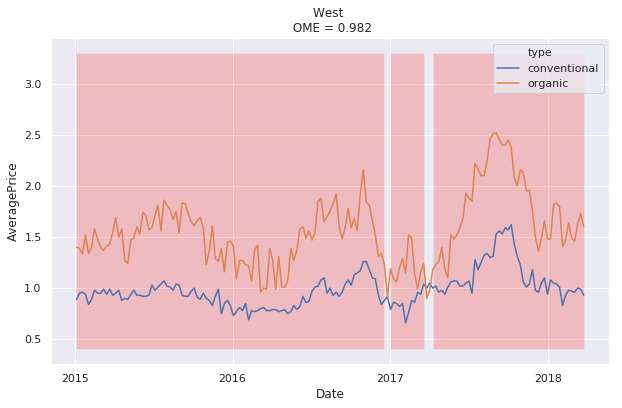

In [17]:
regions_chosen = ['West']

xticks=[pd.to_datetime('2015'), pd.to_datetime('2016'), pd.to_datetime('2017'), pd.to_datetime('2018')]

fig, ax = plt.subplots(figsize = (10,6), subplot_kw=dict(xticks=xticks), sharex=True, sharey=True)

create_filled_subplot(regions_chosen[0], ax = ax, legend = 'brief')

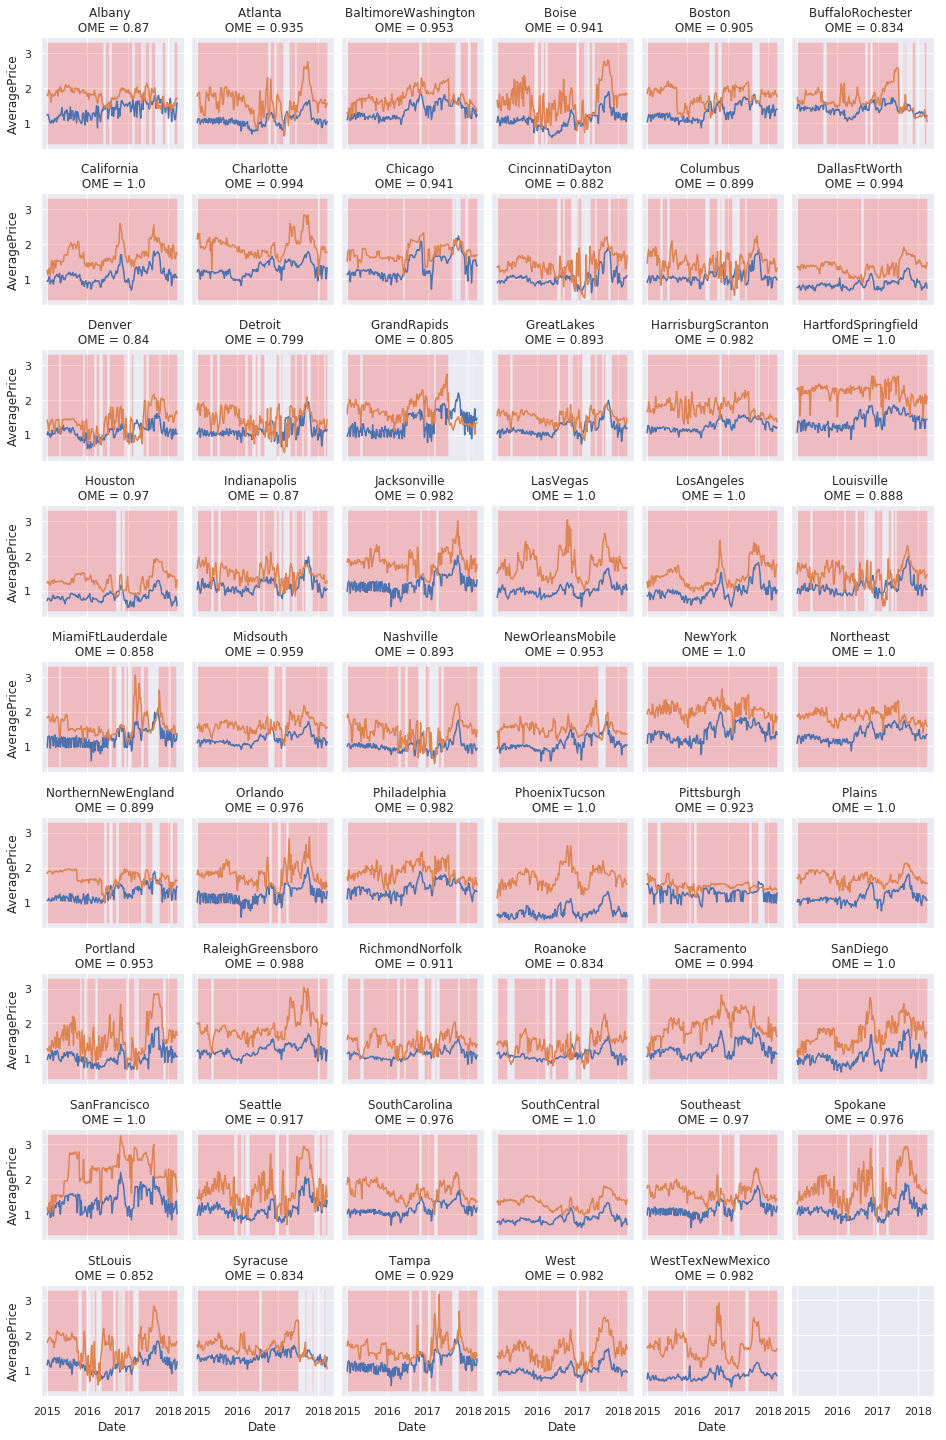

In [18]:
length = len(data.region.unique())
regions_chosen = data.region.unique()

fig, ax = plt.subplots(9, 6, figsize = (16,25), subplot_kw=dict(xticks=xticks), 
                       sharex=True, sharey=True, 
                       gridspec_kw=dict(wspace = 0.05, hspace = 0.4))

for i, axi in enumerate(ax.flat):
    try:
        create_filled_subplot(regions_chosen[i], ax = axi)
    except IndexError:
        pass

After we gained some intuition about "AveragePrice" vs 'region'/'type' we will look at the other columns

In [19]:
data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


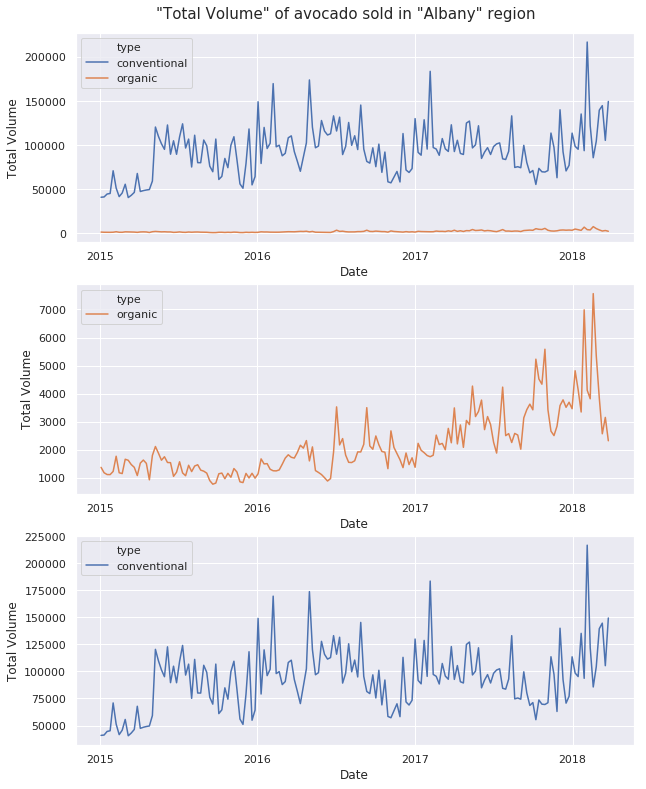

In [20]:
region = 'Albany'
data2 = data[data.region == region]
data2_organic = data2[data2.type == 'organic']
data2_conventional = data2[data2.type == 'conventional']

fig, ax = plt.subplots(3,1, figsize = (10,12), subplot_kw=dict(xticks=xticks))

current_palette = sns.color_palette() # we nned to manually change the 'organic color' 
data_list = [data2, data2_organic, data2_conventional]
palette_list = [[current_palette[0], current_palette[1]], [current_palette[1]], [current_palette[0]]]

for database, axi, palette in zip(data_list, ax, palette_list):
    sns.lineplot(x = database.index, y = 'Total Volume', hue = 'type', palette=palette, 
                 data=database, err_style=None, ax = axi)
    
fig.suptitle('"Total Volume" of avocado sold in "Albany" region', size = 15)
fig.subplots_adjust(top=0.95)

There is a significant difference in amount of pieces sold in two categories 'origanic', 'conventional').
Let's check what are the consequences?

In [21]:
data.groupby('type')['Total Volume'].sum()

type
conventional    9.385999e+09
organic         2.726631e+08
Name: Total Volume, dtype: float64

In [22]:
average_price_mean = pd.DataFrame(data.groupby(['region','type'])['AveragePrice'].mean())
total_volume_sum = pd.DataFrame(data.groupby(['region','type'])['Total Volume'].sum())

In [23]:
total_volume_sum.head(6)

Total Volume
region              type                      
Albany              conventional  1.570061e+07
                    organic       3.671885e+05
Atlanta             conventional  8.666139e+07
                    organic       1.943727e+06
BaltimoreWashington conventional  1.307456e+08
                    organic       3.968344e+06

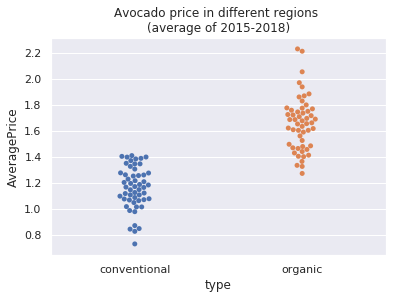

In [24]:
sns.swarmplot(x = average_price_mean.index.droplevel(0), y = 'AveragePrice', data=average_price_mean)
plt.gca().set_title('Avocado price in different regions \n(average of 2015-2018)');

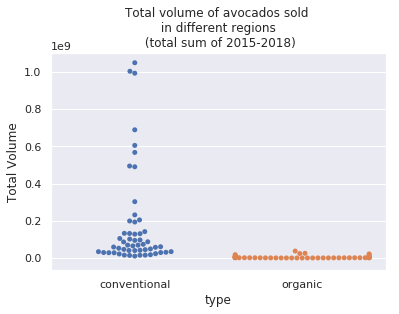

In [25]:
sns.swarmplot(x = total_volume_sum.index.droplevel(0), y = 'Total Volume', data=total_volume_sum)
plt.gca().set_title('Total volume of avocados sold \n in different regions \n (total sum of 2015-2018)');

OK. Let's leave "Toal Volume" and "AveragePrice" for a while. Another columns' headers "4046", "4225", "4770" look suspecious. In dataset description we can find:

"Numerical column names refer to price lookup codes.
4046 - small Hass
4225 - large Hass
4770 - extra large Hass"

Can we tame them just a little?

In [26]:
data.describe().round(2)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
count,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00
mean,1.41,539258.69,183807.41,188223.11,14551.23,152675.73,116202.87,34505.69,1967.17
std,0.40,1224331.91,515105.86,451985.65,48817.54,364599.23,278759.60,113947.74,8186.40
min,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.10,10571.02,819.66,2909.61,0.00,4905.20,2700.34,113.00,0.00
50%,1.37,100154.13,7824.43,26701.99,164.23,37551.02,24530.62,2459.22,0.00
75%,1.67,400176.68,101488.82,131755.22,5736.74,103691.60,79282.59,19421.71,106.76
max,3.25,11274749.11,5160896.68,5402444.45,804558.25,4145406.70,3403581.49,2838239.39,131300.76


In [27]:
data2_plu = data.pivot_table(['4046', '4225', '4770'], index=['region'], columns=['type']).stack(level = 0).round(2)
data2_plu = data2_plu.assign(PLU = data2_plu.index.droplevel(0))
data2_plu.head(6)

type          conventional  organic   PLU
region                                   
Albany  4046       3547.48   100.69  4046
        4225      75028.35   214.07  4225
        4770        325.66     0.00  4770
Atlanta 4046     290764.01  1469.73  4046
        4225      58106.04  4330.98  4225
        4770        622.77     0.00  4770

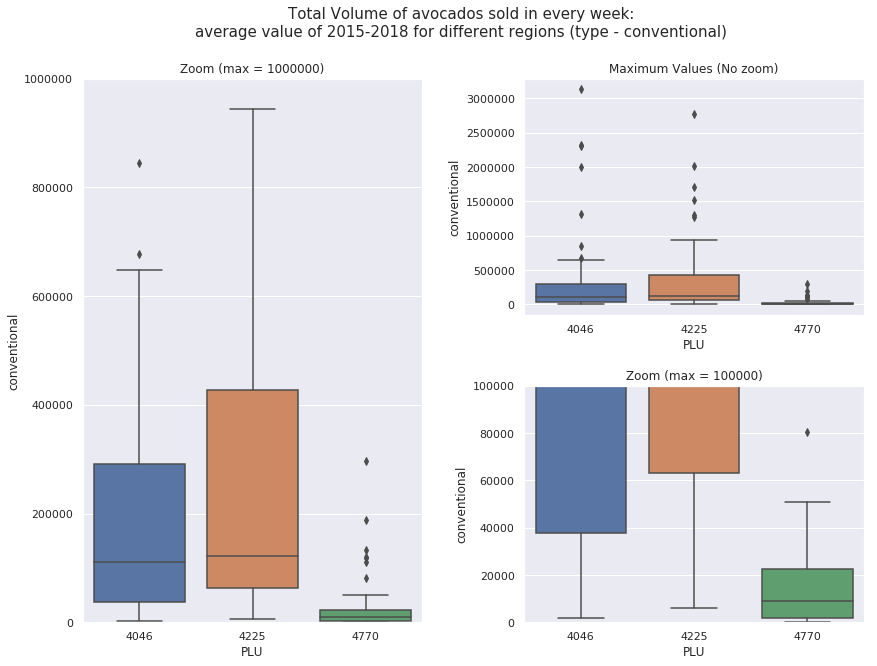

In [28]:
fig, ax = plt.subplots(figsize = (14,10))

max1 = 1000000
ax1 = plt.subplot(121)
sns.boxplot(x = 'PLU', y = 'conventional', data=data2_plu, ax=ax1)
ax1.set_ylim(0,max1)
ax1.set_title('Zoom (max = {})'.format(max1))

ax2 = plt.subplot(222)
sns.boxplot(x = 'PLU', y = 'conventional', data=data2_plu, ax=ax2)
ax2.set_title('Maximum Values (No zoom)')

max3 = 100000
ax3 = plt.subplot(224)
sns.boxplot(x = 'PLU', y = 'conventional', data=data2_plu, ax=ax3)
ax3.set_ylim(0, max3)
ax3.set_title('Zoom (max = {})'.format(max3))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.suptitle(
"""Total Volume of avocados sold in every week:
average value of 2015-2018 for different regions (type - conventional)""", size = 15);

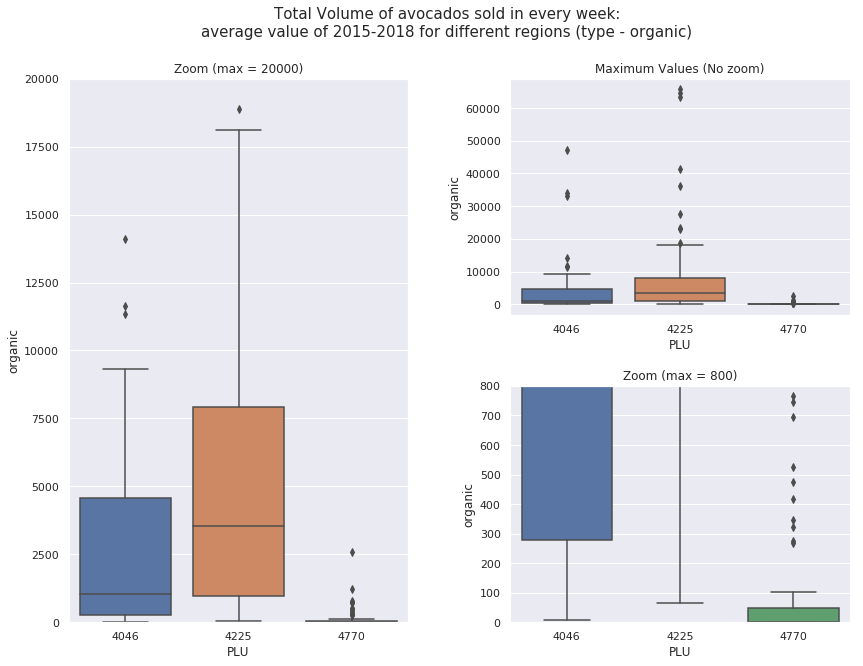

In [29]:
fig, ax = plt.subplots(figsize = (14,10))

max1 = 20000
ax1 = plt.subplot(121)
sns.boxplot(x = 'PLU', y = 'organic', data=data2_plu, ax=ax1)
ax1.set_ylim(0,max1)
ax1.set_title('Zoom (max = {})'.format(max1))

ax2 = plt.subplot(222)
sns.boxplot(x = 'PLU', y = 'organic', data=data2_plu, ax=ax2)
ax2.set_title('Maximum Values (No zoom)')

max3 = 800
ax3 = plt.subplot(224)
sns.boxplot(x = 'PLU', y = 'organic', data=data2_plu, ax=ax3)
ax3.set_ylim(0, max3)
ax3.set_title('Zoom (max = {})'.format(max3))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.suptitle(
"""Total Volume of avocados sold in every week:
average value of 2015-2018 for different regions (type - organic)""", size = 15);

All of these preparations may look a little weird but they helped us to familiarize ourself with the data and catch howlers with the intuiton in the future.

## Chapter 3. Preparing the dataset for machine learning

We will try to predict the "AveragePrice" using the "Average Price" and "Total Volume" of preceding weeks. 

One thing demands more explanation. "Total Volume" refers to the same time period as "AveragePrice". We need to consider one very important issue: Will "Total Volume" be known at the time when we will be forced to predict "AveragePrice"? We are not sure about this. At this moment we assume this value is available.

First we will try to find if there is any relationship visible with the naked eye. Let's make some basic plots.

In [30]:
data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


In [31]:
chosen_type = 'conventional'
chosen_region = 'California'

data3 = data[(data.region == chosen_region) & (data.type == chosen_type)]
data3 = data3[['AveragePrice', 'Total Volume']].sort_index()
data3.head()

,AveragePrice,Total Volume
Date,,
2015-01-04,0.93,5777334.90
2015-01-11,0.92,6024932.34
2015-01-18,1.02,5570915.26
2015-01-25,1.06,4929884.26
2015-02-01,0.85,9032180.67


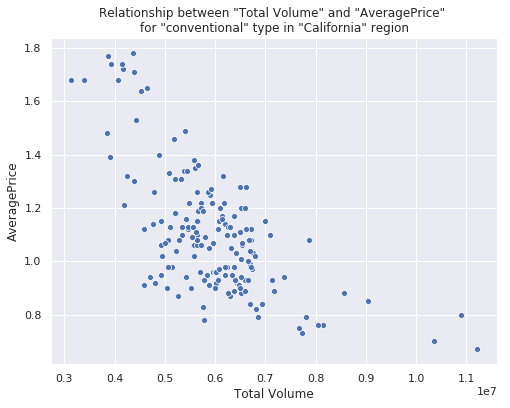

In [32]:
fig, ax = plt.subplots(1, figsize = (8,6))

sns.scatterplot(x = 'Total Volume', y = 'AveragePrice', data = data3, ax=ax);
plt.gca().set_title(
'''Relationship between "Total Volume" and "AveragePrice" 
for "conventional" type in "California" region''');

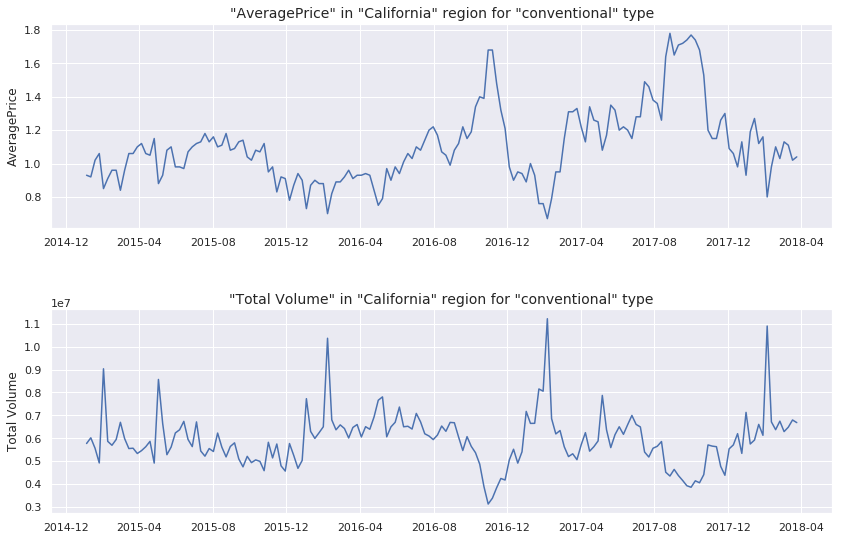

In [33]:
fig, ax = plt.subplots(2, figsize = (14,9), gridspec_kw = dict(hspace = 0.4))
sns.lineplot(x = data3.index.values, y = 'AveragePrice', data=data3, ax = ax[0])
sns.lineplot(x = data3.index.values, y = 'Total Volume', data=data3, ax = ax[1]);

ax[0].set_title('"AveragePrice" in "California" region for "conventional" type', size = 14) 
ax[1].set_title('"Total Volume" in "California" region for "conventional" type', size = 14);

In [34]:
data3_past = pd.concat([data3, data3.shift(1), data3.shift(2), data3.shift(4)], axis=1).dropna()
data3_past.columns = ['AveragePrice', 'Total Volume', 'AP_1', 'TV_1', 'AP_2', 'TV_2', 'AP_4', 'TV_4']
data3_past.head()

,AveragePrice,Total Volume,AP_1,TV_1,AP_2,TV_2,AP_4,TV_4
Date,,,,,,,,
2015-02-01,0.85,9032180.67,1.06,4929884.26,1.02,5570915.26,0.93,5777334.90
2015-02-08,0.91,5871224.58,0.85,9032180.67,1.06,4929884.26,0.92,6024932.34
2015-02-15,0.96,5699944.93,0.91,5871224.58,0.85,9032180.67,1.02,5570915.26
2015-02-22,0.96,5951871.32,0.96,5699944.93,0.91,5871224.58,1.06,4929884.26
2015-03-01,0.84,6700134.25,0.96,5951871.32,0.96,5699944.93,0.85,9032180.67


In [35]:
X = data3_past.iloc[:, 1:]
y = data3_past.iloc[:, 0][:, np.newaxis]

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y) #calculated only for the purpose of visualization

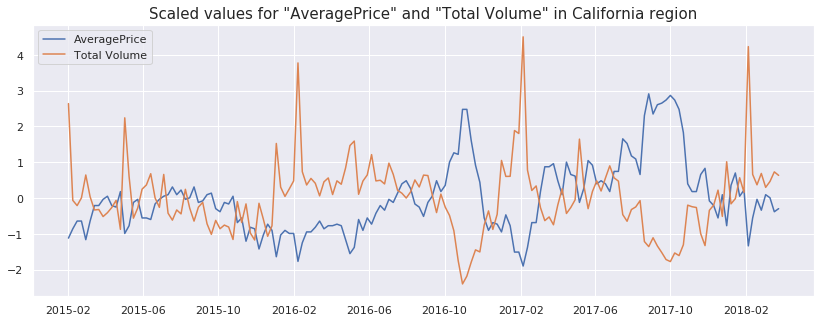

In [36]:
fig, ax = plt.subplots(figsize = (14,5))
sns.lineplot(x = data3_past.index.values, y = y_scaled.ravel(), label = 'AveragePrice')
sns.lineplot(x = data3_past.index.values, y = X_scaled[:, 0], label = 'Total Volume')
plt.legend()
ax.set_title('Scaled values for "AveragePrice" and "Total Volume" in {} region'.format(chosen_region), size = 15);

When "Total Volume" rises "AveragePrice" decreases and vice versa! (Sherlock Holmes would be proud of us...)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 0)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_fit = model_lr.predict(X_test)

mae = mean_absolute_error(y_test, y_fit)
score = model_lr.score(X_test, y_test)

print('Mean absolute error (test set) = {}'.format(np.round(mae,4)))
print('Coefficient of determination R^2 (test set) = {}'.format(np.round(score, 4)))

Mean absolute error (test set) = 0.0564
Coefficient of determination R^2 (test set) = 0.8973


In chapter 3 we noticed that there is a kind of relationship between "AveragePrice" and "Total Volume". Using of machine learning might give us some meaningful results.

## Chapter 4. Try Machine Learning 

We wil try to use a couple of algorithms to predict the 'AveragePrice' in one region. Let's see what happens.

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

def predict_price(chosen_region, chosen_type, model_estimator, 
                  param_grid, test_size = 0.2, KFold_split = 4, 
                  to_print=True, random_state = 0, to_ravel_y = False):
    
    dataset = data[(data.region == chosen_region) & (data.type == chosen_type)]
    dataset = dataset[['AveragePrice', 'Total Volume']].sort_index()
    dataset_past = pd.concat([dataset, dataset.shift(1), dataset.shift(2), dataset.shift(4)], axis=1).dropna()
    dataset_past.columns = ['AveragePrice', 'Total Volume', 'AP_1', 'TV_1', 'AP_2', 'TV_2', 'AP_4', 'TV_4']
    
    X = dataset_past.iloc[:, 1:]
    y = dataset_past.iloc[:, 0][:, np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    if to_ravel_y:
        y_train = y_train.ravel()
        y_test = y_test.ravel()
    
    est1_step = ('est1', StandardScaler())
    est2_step = ('est2', model_estimator)
    steps = [est1_step, est2_step]
    pipe = Pipeline(steps)
    
    kf = KFold(n_splits=KFold_split, shuffle=True, random_state=random_state)
    gs = GridSearchCV(pipe, param_grid=param_grid, cv = kf, scoring='neg_mean_absolute_error')
    gs.fit(X_train, y_train);
    
    model = gs.best_estimator_
    y_predicted = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predicted)
    score = model.score(X_test, y_test)
    
    if to_print:
        print(gs.best_params_)
        print('Mean absolute error (test set) = {}'.format(np.round(mae,4)))
        print('Coefficient of determination R^2 (test set) = {}'.format(np.round(score, 4)))
    return (model, mae, score)

In [39]:
from sklearn.linear_model import Ridge

param_grid = {
    'est2__alpha':[0, 0.1, 0.5, 1, 5, 10]
}
predict_price('West', 'conventional', Ridge(), param_grid);

{'est2__alpha': 1}
Mean absolute error (test set) = 0.0377
Coefficient of determination R^2 (test set) = 0.9447


In [40]:
# from sklearn.linear_model import LinearRegression

param_grid = {}
predict_price('West', 'conventional', LinearRegression(), param_grid);

{}
Mean absolute error (test set) = 0.0378
Coefficient of determination R^2 (test set) = 0.9451


In [41]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'est2__n_estimators':[100, 200, 300],
    'est2__learning_rate':[0.01, 0.05, 0.1, 0.2],
    'est2__max_depth': [2, 3, 4],
    'est2__subsample': [0.5, 0.6, 0.7, 0.8],
    'est2__min_samples_split':[2, 4, 8]
}

predict_price('West', 'conventional', GradientBoostingRegressor(), param_grid, to_ravel_y=True);

{'est2__learning_rate': 0.1, 'est2__max_depth': 2, 'est2__min_samples_split': 2, 'est2__n_estimators': 200, 'est2__subsample': 0.6}
Mean absolute error (test set) = 0.0426
Coefficient of determination R^2 (test set) = 0.927


In [42]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'est2__n_neighbors':[2, 3, 4],
    'est2__weights':['uniform', 'distance'],
    'est2__algorithm':['ball_tree', 'kd_tree', 'brute', 'auto'],
    'est2__leaf_size':[2, 3, 5]
}

predict_price('West', 'conventional', KNeighborsRegressor(), param_grid);

{'est2__algorithm': 'ball_tree', 'est2__leaf_size': 2, 'est2__n_neighbors': 3, 'est2__weights': 'distance'}
Mean absolute error (test set) = 0.0438
Coefficient of determination R^2 (test set) = 0.9105


If we compare "MAE" then Ridge algorithm has the best performance. We will choose it for further calculations.

Now our goal is to compare "Ridge" performance for different regions using "Mean Absolute Error" and "Coefficient of determination R^2"

In [43]:
algoritm_chosen = Ridge(alpha=1)
types_chosen = data.type.unique()
regions_chosen = data.region.unique()

conventional_dict = {}
for region in regions_chosen:
    model, mae, score = predict_price(region, 'conventional', algoritm_chosen, {}, to_print=False)
    conventional_dict[region] = (mae, score)
    
organic_dict = {}
for region in regions_chosen:
    model, mae, score = predict_price(region, 'organic', algoritm_chosen, {}, to_print=False)
    organic_dict[region] = (mae, score)

/home/lcs123/anaconda3/envs/ds1/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
conventional_df = pd.DataFrame(conventional_dict).T
conventional_df.columns = ['mae', 'score']
conventional_df['type'] = 'conventional'
conventional_df.head()

,mae,score,type
Albany,0.109301,0.517598,conventional
Atlanta,0.045117,0.913691,conventional
BaltimoreWashington,0.051441,0.906194,conventional
Boise,0.069921,0.899150,conventional
Boston,0.044062,0.945511,conventional


In [45]:
organic_df = pd.DataFrame(organic_dict).T
organic_df.columns = ['mae', 'score']
organic_df.columns.names = ['organic']
organic_df['type'] = 'organic'
organic_df.head()

organic,mae,score,type
Albany,0.073849,0.748601,organic
Atlanta,0.111357,0.888184,organic
BaltimoreWashington,0.096049,0.726751,organic
Boise,0.131861,0.867272,organic
Boston,0.094517,0.760705,organic


In [46]:
summary_df = pd.concat([conventional_df, organic_df], axis = 0).sort_index().reset_index()
summary_df.columns = ['region', 'mae', 'score', 'type']

marker_sizes = data.groupby(['region', 'type'], as_index=False)[['Total Volume']].mean()
summary_df = pd.merge(summary_df, marker_sizes, how='inner', on=['region', 'type'])
summary_df['log10(Total Volume)'] = np.log10(summary_df['Total Volume'])

summary_df.head()

,region,mae,score,type,Total Volume,log10(Total Volume)
0,Albany,0.109301,0.517598,conventional,92903.026450,4.968030
1,Albany,0.073849,0.748601,organic,2172.713018,3.337002
2,Atlanta,0.045117,0.913691,conventional,512789.298817,5.709939
3,Atlanta,0.111357,0.888184,organic,11501.345266,4.060749
4,BaltimoreWashington,0.051441,0.906194,conventional,773642.458166,5.888540


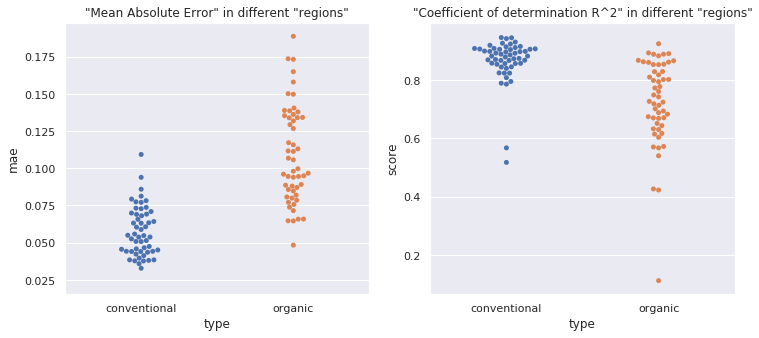

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.swarmplot(x = 'type', y = 'mae', data = summary_df, ax = ax[0])
sns.swarmplot(x = 'type', y = 'score', data = summary_df, ax = ax[1]);
ax[0].set_title('"Mean Absolute Error" in different "regions"')
ax[1].set_title('"Coefficient of determination R^2" in different "regions"');

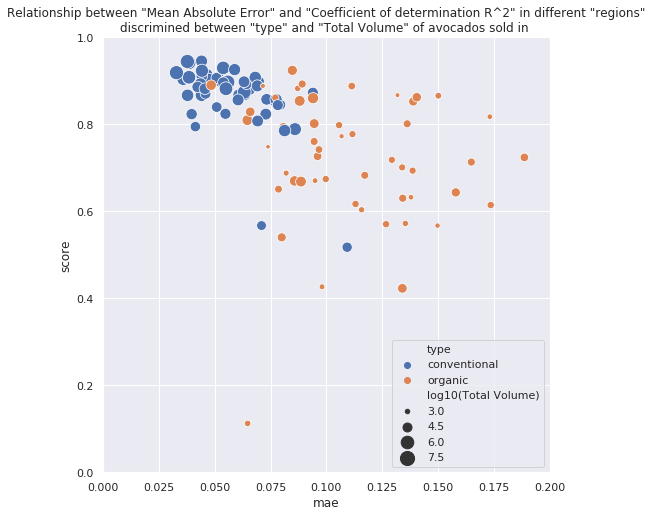

In [48]:
x_lim = (0, 0.2)
y_lim = (0, 1)

fig, ax = plt.subplots(figsize = (8,8))
g = sns.scatterplot(x = 'mae', y = 'score', 
                hue = 'type', data = summary_df,
                sizes=(20, 200),
                ax = ax, size = 'log10(Total Volume)');
plt.legend(loc = 'lower right')
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
ax.set_title(
'''Relationship between "Mean Absolute Error" and "Coefficient of determination R^2" in different "regions"
discrimined between "type" and "Total Volume" of avocados sold in ''');

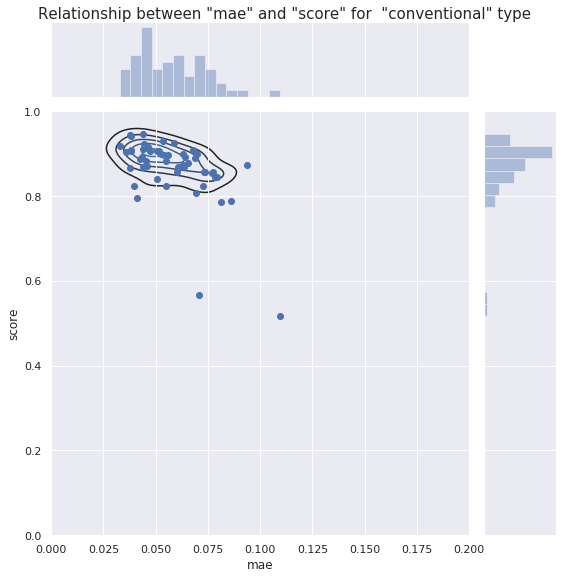

In [49]:
g = (sns.jointplot(x = 'mae', y = 'score', data = summary_df[summary_df.type == 'conventional'],
                   kind='scatter', height=8, xlim=x_lim, ylim=y_lim, 
                  marginal_kws = dict(bins=15)).plot_joint(sns.kdeplot, zorder=0, n_levels=5))

plt.suptitle('''Relationship between "mae" and "score" for  "conventional" type''', x = 0.5, y = 1.0, size = 15);

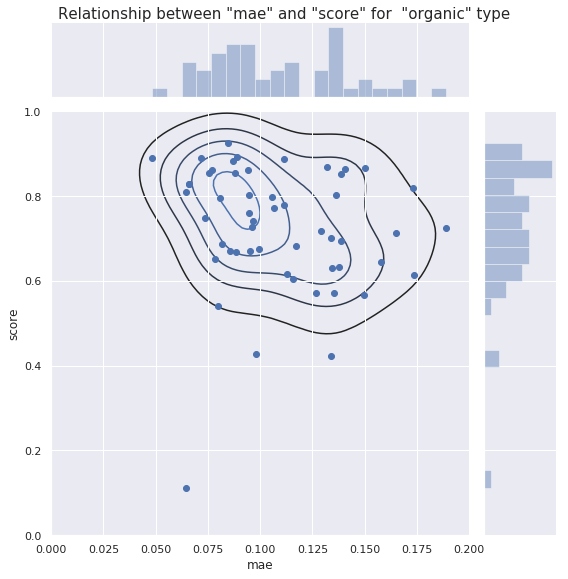

In [50]:
g = (sns.jointplot(x = 'mae', y = 'score', data = summary_df[summary_df.type == 'organic'],
                   kind='scatter', height=8, xlim=x_lim, ylim=y_lim, 
                  marginal_kws = dict(bins=20)).plot_joint(sns.kdeplot, zorder=0, n_levels=5))

plt.suptitle('''Relationship between "mae" and "score" for  "organic" type''', x = 0.5, y = 1.0, size = 15);

## Chapter 5. Summary and conclusions 

1. 'Avocado Prices' dataset is clear. There were only 3 observations missing (total number of observations 17911). Zero 'NaN' was spotted.
2. Some of features occured to be linearly dependent.
3. Because of significant difference in "Total Volume" for two "types", their analysis was executed in two separated ways. At the end results were compared.
4. There was assumed a separated analysis for particular "regions".
5. Two goal indicators were assumed "Mean Absolute Error" (mae) and "Coefficient of determination R^2" (score).
6. Despite very small dataset (169 observations per "region" per "type), our analysis gave satisfying results for the "conventional" type.
7. For the overall analysis "Ridge" algorithm was chosen because it gave the best results in mae goal indicators.
8. "conventional" type occured to be by far easier to predict than "organic" type.